In [1]:
import numpy as np
import scipy.stats as stats
import vectorbt as vbt
import warnings
warnings.filterwarnings('ignore')

In [2]:
start = "2016-01-01 UTC"
end = "2020-01-01 UTC"
prices = vbt.YFData.download(
    "AAPL",
    start=start,
    end=end
).get("Close")

In [3]:
prices.vbt.rolling_split(
    n=30,
    window_len=365 * 2,
    set_lens=(180,),
    left_to_right=False,
    plot=True
)

FigureWidget({
    'data': [{'colorscale': [[0.0, '#1f77b4'], [1.0, '#1f77b4']],
              'hoverongaps': False,
              'name': '0',
              'showlegend': True,
              'showscale': False,
              'type': 'heatmap',
              'uid': '69ea5ef5-1f2e-40f8-8447-253cbc477e4e',
              'x': array([datetime.datetime(2016, 1, 4, 5, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2016, 1, 5, 5, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2016, 1, 6, 5, 0, tzinfo=datetime.timezone.utc), ...,
                          datetime.datetime(2019, 12, 27, 5, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2019, 12, 30, 5, 0, tzinfo=datetime.timezone.utc),
                          datetime.datetime(2019, 12, 31, 5, 0, tzinfo=datetime.timezone.utc)],
                         dtype=object),
              'y': array([29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15

In [4]:
(in_price, in_indexes), (out_price, out_indexes) = prices.vbt.rolling_split(
    n=30,
    window_len=365 * 2,
    set_lens=(180,),
    left_to_right=False,
    plot=False
)

In [5]:
def simulate_all_params(price, windows, **kwargs):
    fast_ma, slow_ma = vbt.MA.run_combs(
        price,
        windows,
        r=2,
        short_names=["fast", "slow"]
    )

    entries = fast_ma.ma_crossed_above(slow_ma)
    exits = fast_ma.ma_crossed_below(slow_ma)

    pf = vbt.Portfolio.from_signals(
        price, entries, exits, **kwargs)
    
    return pf.sharpe_ratio()
    

In [6]:
in_sharpe = simulate_all_params(
    in_price,
    np.arange(10, 40),
    direction="both",
    freq="d"
)

In [7]:
in_sharpe.vbt.plot()

FigureWidget({
    'data': [{'name': 'sharpe_ratio',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'c34b25fa-37f5-41ad-b206-1ac90f57972b',
              'x': [(10, 11, 0), (10, 11, 1), (10, 11, 2), ..., (38, 39, 27), (38,
                    39, 28), (38, 39, 29)],
              'y': array([ 1.48300581,  1.31568116,  1.38261269, ..., -0.87533184, -0.80065364,
                          -0.69531131])}],
    'layout': {'height': 350,
               'legend': {'orientation': 'h',
                          'traceorder': 'normal',
                          'x': 1,
                          'xanchor': 'right',
                          'y': 1.02,
                          'yanchor': 'bottom'},
               'margin': {'b': 30, 'l': 30, 'r': 30, 't': 30},
               'template': '...',
               'width': 700}
})

In [8]:
# Extract the best index
best_index = in_sharpe.idxmax()  # Gets the index (tuple of parameters) for max Sharpe ratio
best_sharpe = in_sharpe.max()   # Max Sharpe ratio

# If `best_index` is already a tuple (like (24, 25, 21)), no further processing is needed
print(f"Best Sharpe Ratio: {best_sharpe}")
print(f"Best Parameters: {best_index}")

# Optionally, unpack the tuple for clarity
fast_ma, slow_ma, other_param = best_index
print(f"Fast Moving Average: {fast_ma}")
print(f"Slow Moving Average: {slow_ma}")

Best Sharpe Ratio: 2.1476880920076167
Best Parameters: (24, 25, 21)
Fast Moving Average: 24
Slow Moving Average: 25


In [9]:
def simulate_best_params(price, best_fast_windows, best_slow_windows, **kwargs):
    # Calculate the fast moving average
    fast_ma = vbt.MA.run(
        price,
        window=best_fast_windows,
        per_column=True
    )
    
    # Calculate the slow moving average
    slow_ma = vbt.MA.run(
        price,
        window=best_slow_windows,
        per_column=True
    )
    
    # Define entry and exit signals based on moving average crossovers
    entries = fast_ma.ma_crossed_above(slow_ma)
    exits = fast_ma.ma_crossed_below(slow_ma)
    
    # Create a portfolio based on the signals
    pf = vbt.Portfolio.from_signals(price, entries, exits, **kwargs)
    
    # Return the Sharpe ratio of the portfolio
    return pf.sharpe_ratio()

In [10]:
# Simulate using the best parameters
out_test_sharpe = simulate_best_params(
    out_price,  # Out-of-sample price data
    fast_ma,
    slow_ma,
    direction="both",  # Allow both long and short positions
    freq="d"  # Daily frequency
)

In [11]:
out_test_sharpe.mean()

1.7105071911022947

In [13]:
# Perform the t-test
t_stat, p_value = stats.ttest_ind(
    a=out_test_sharpe,  # Out-of-sample Sharpe ratios
    b=in_sharpe[best_index],  # In-sample Sharpe ratios for best parameters
    alternative="greater"  # One-sided test: testing if out > in
)

# Print the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("The strategy is statistically significant.")
else:
    print("The strategy is NOT statistically significant (likely overfitted).")

T-statistic: -0.2704267367239909
P-value: 0.6056263432582751
The strategy is NOT statistically significant (likely overfitted).


In [21]:
print(in_sharpe)

fast_window  slow_window  split_idx
10           11           0            1.483006
                          1            1.315681
                          2            1.382613
                          3            1.266850
                          4            0.830675
                                         ...   
38           39           25          -1.096167
                          26          -1.041615
                          27          -0.875332
                          28          -0.800654
                          29          -0.695311
Name: sharpe_ratio, Length: 13050, dtype: float64


<Axes: title={'center': 'Out-of-Sample Sharpe Ratios by Split'}, xlabel='ma_window,ma_window,split_idx'>

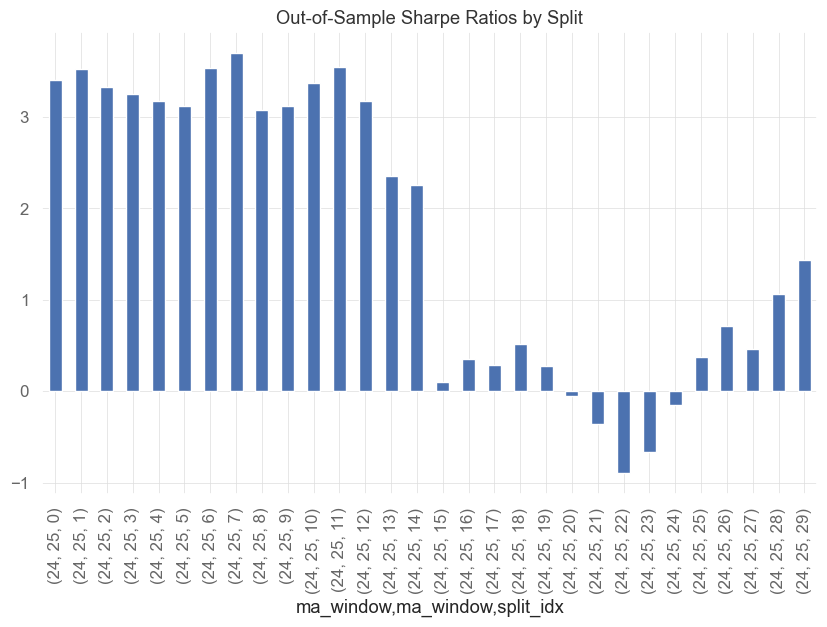

In [18]:
out_test_sharpe.plot(kind='bar', title="Out-of-Sample Sharpe Ratios by Split")

In [22]:
mean_sharpe_by_params = in_sharpe.groupby(['fast_window', 'slow_window']).mean()


In [26]:
in_sharpe

fast_window  slow_window  split_idx
10           11           0            1.483006
                          1            1.315681
                          2            1.382613
                          3            1.266850
                          4            0.830675
                                         ...   
38           39           25          -1.096167
                          26          -1.041615
                          27          -0.875332
                          28          -0.800654
                          29          -0.695311
Name: sharpe_ratio, Length: 13050, dtype: float64

In [25]:
mean_sharpe_by_params

fast_window  slow_window
10           11             0.724289
             12             0.376423
             13             0.309320
             14             0.304010
             15             0.153965
                              ...   
36           38            -0.583303
             39            -0.447758
37           38            -0.957788
             39            -0.843257
38           39            -0.768817
Name: sharpe_ratio, Length: 435, dtype: float64

In [23]:
best_params = mean_sharpe_by_params.idxmax()  # Gets the best (fast_window, slow_window) pair
best_mean_sharpe = mean_sharpe_by_params.max()  # Gets the max mean Sharpe ratio


In [24]:
print(f"Best Mean Sharpe Ratio: {best_mean_sharpe}")
print(f"Best Parameters: Fast MA = {best_params[0]}, Slow MA = {best_params[1]}")


Best Mean Sharpe Ratio: 0.9982753055480332
Best Parameters: Fast MA = 18, Slow MA = 23


In [ ]:
# Perform the t-test
t_stat, p_value = stats.ttest_ind(
    a=out_test_sharpe,  # Out-of-sample Sharpe ratios
    b=in_sharpe[best_index],  # In-sample Sharpe ratios for best parameters
    alternative="greater"  # One-sided test: testing if out > in
)

# Print the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("The strategy is statistically significant.")
else:
    print("The strategy is NOT statistically significant (likely overfitted).")